# Histogram-based EDA

_Author:_ Dan Shaked-Renous

The purpose of this notebook is to explore the different information that can be extracted using the grayscale spectrum of the images. 

__After reading this notebook__ you should understand:
- The definition of high-quality (HQ) images.
- The calculation of optimal threshold for HQ images binary filtering.

__Summary of the notebook results__:
- The HQ images are defined with high contrast between the weld and the background.
- The high contrast is demonstrated by a pronounced peak in the grayscale histogram that follows the dark peaks of the background.
- We suggest an optimal threshold for HQ images as the minimum point between the dark peaks and the weld peak.
- In this notebook we present the following functions:
    - Sorted Peak finder
    - Optimal threshold and its optimization range finder
- A .csv file that contains all the images name, histogram peaks location (index), optimal threshold, and optimization range.

In [234]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.exposure import histogram
from skimage import filters as flt
import os
import sys

# Add /scr/data folder to your system path
sys.path.append(os.pardir + '/src/data')

import eda_helper as eh

import importlib
from scipy.signal import find_peaks
from scipy.signal import savgol_filter


In [235]:
#### SETTING UP CONSTANT GLOBAL VERIABLES #########

HOME =  os. path.expanduser('~')+'/Spring23_EPRI_Blue/'
IMG_DIR = 'data/interim/merged_data/not_measured/'

###################################################

In [236]:
img_list_not_measured = os.listdir(HOME+IMG_DIR)


Loading a subset of images

In [237]:
sample_list = img_list_not_measured[5:10]
subset = [rgb2gray(io.imread(HOME+IMG_DIR+fname)) for fname in sample_list]

# hist data is saved in tuples of the sturcture [hist, hist_centers]
subset_hist = [ histogram(gray, nbins=256) for gray in subset]

In [238]:
# Reload modules
importlib.reload(eh)

<module 'eda_helper' from '../src/data/eda_helper.py'>

First exploration of the histograms of some images from the database.

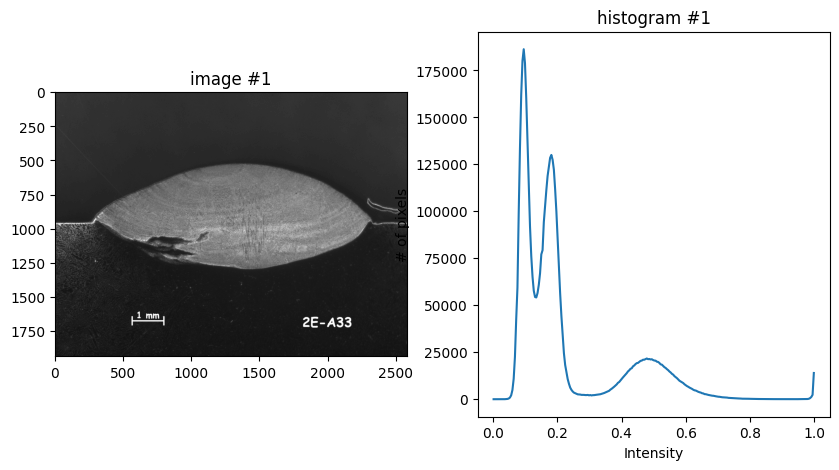

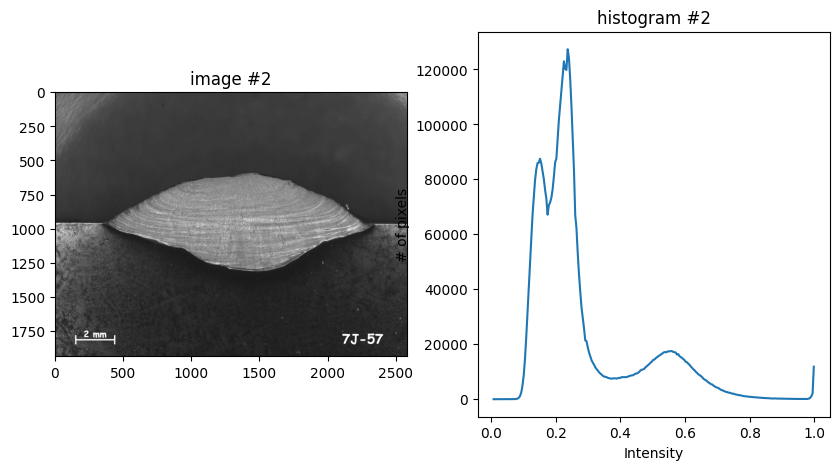

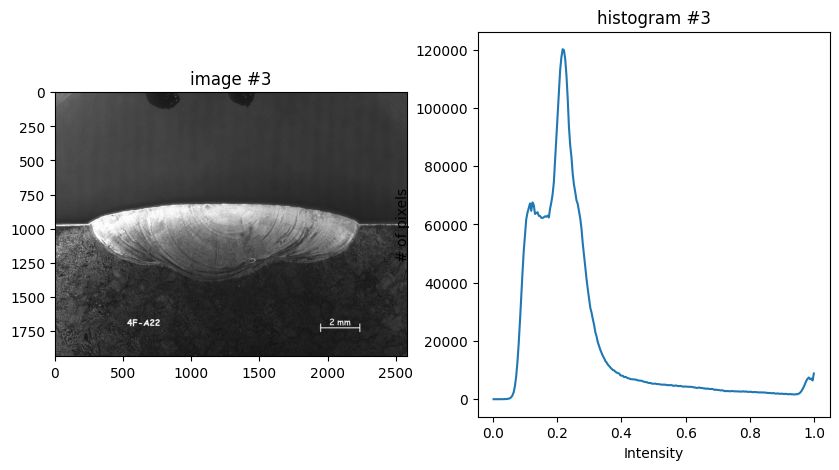

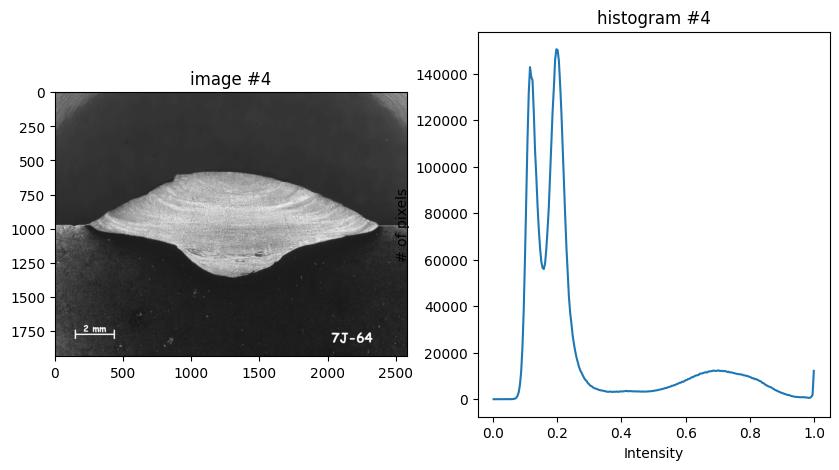

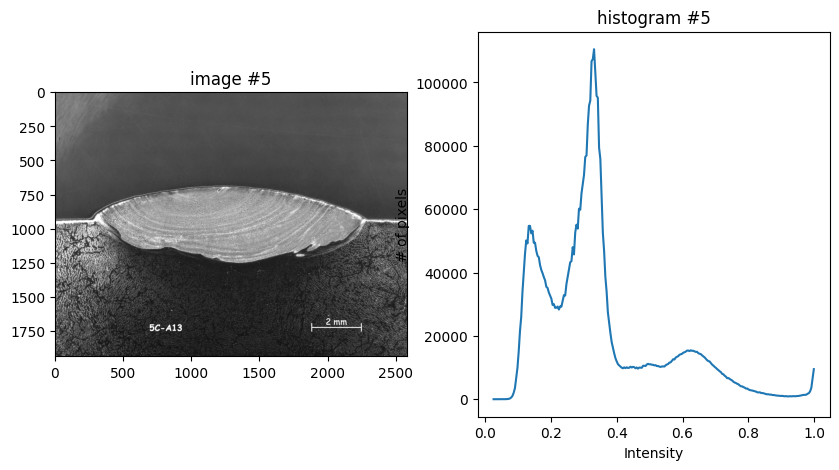

In [239]:
for i, sample in enumerate(subset):
    eh.sideBside(sample, sample, ttl1='image #{}'.format(i+1), ttl2='histogram #{}'.format(i+1), type='hist')


Notice that the images with the good contrast between the weld and the background have a 3rd well-defined peak in the higher intensity values. The two highest peaks in the lower values corresponds to the two different types of background shades. 

# Peak finder

As noticed above, all the histograms are charaterized with sharp and high prominant peaks in the dark side of the spectrum (<.5). In images with high contrast between the weld and the background,a wide and lower peak is visible in the higher intensity values. The rise in the end of the spectrum comes from the pixales of the lable and the scale. <br>
<br>
The objective of this section is to devise a function that can find all the peaks in the histogram of an image. The initial peak finding tool is `scipy.signal.find_peaks`.

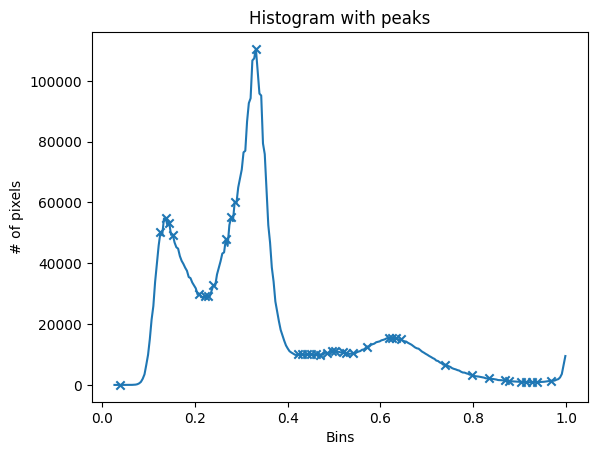

In [240]:
plt.plot(subset_hist[4][1], subset_hist[4][0])

peaks, _ = find_peaks(subset_hist[4][0])
plt.scatter(subset_hist[4][1][peaks], subset_hist[4][0][peaks], marker="x")
plt.title("Histogram with peaks")
plt.xlabel('Bins')
plt.ylabel('# of pixels')
plt.show()

The raw histograms require some smoothing to find the dominant peaks. For this purpose I used the ` scipy.signal.savgol_filter `.

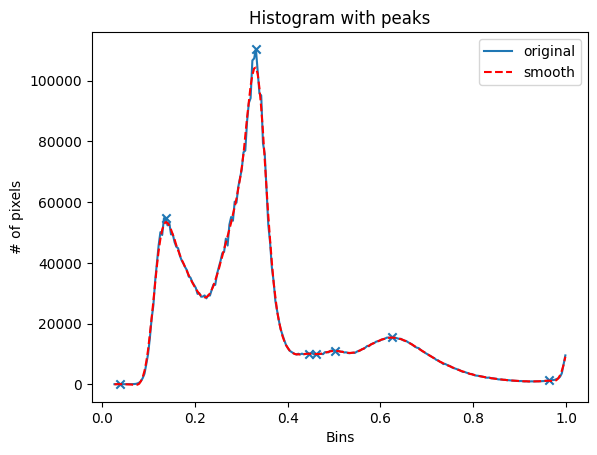

In [241]:
yhat = savgol_filter(subset_hist[4][0], 15, 3) # window size 15, polynomial order 3
plt.plot(subset_hist[4][1], subset_hist[4][0], label='original')
plt.plot(subset_hist[4][1], yhat, 'r--', label='smooth')
peaks, _ = find_peaks(yhat)
plt.scatter(subset_hist[4][1][peaks], subset_hist[4][0][peaks], marker="x")
plt.title("Histogram with peaks")
plt.xlabel('Bins')
plt.ylabel('# of pixels')
plt.legend()
plt.show()

Even after smoothing the peak-finder catches other insignificant peaks. In the next cell I added a peak-height threshold of 10k pixels. 

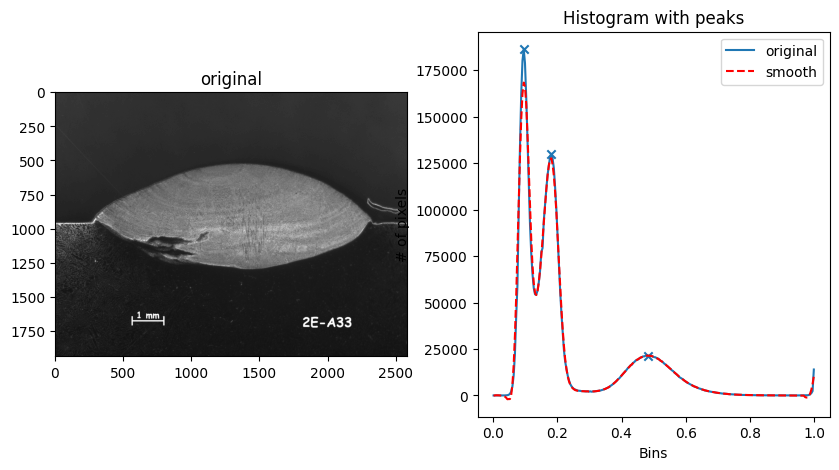

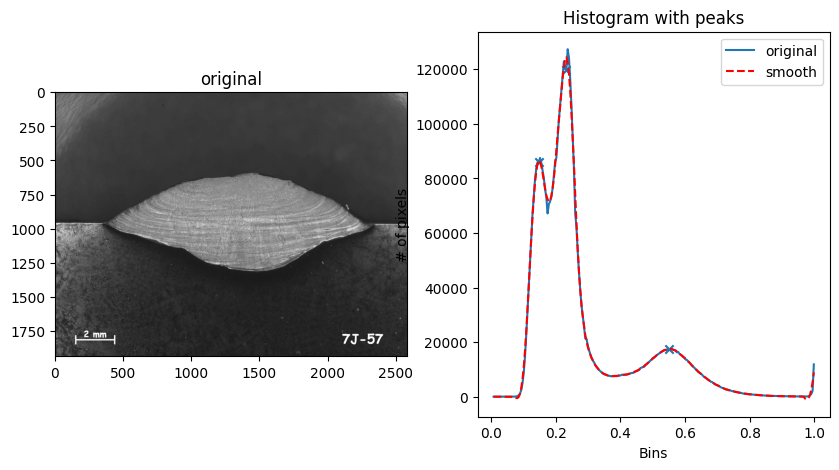

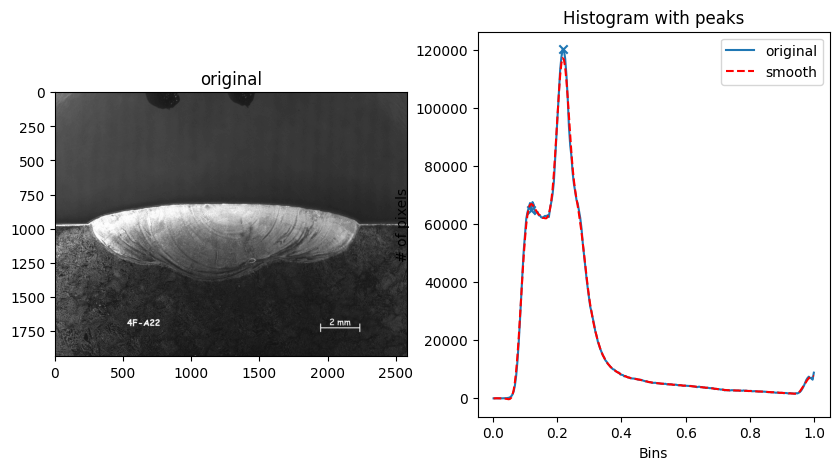

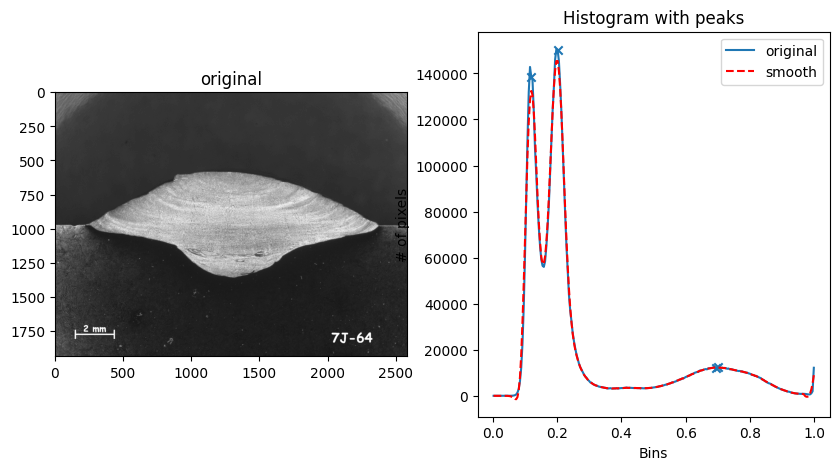

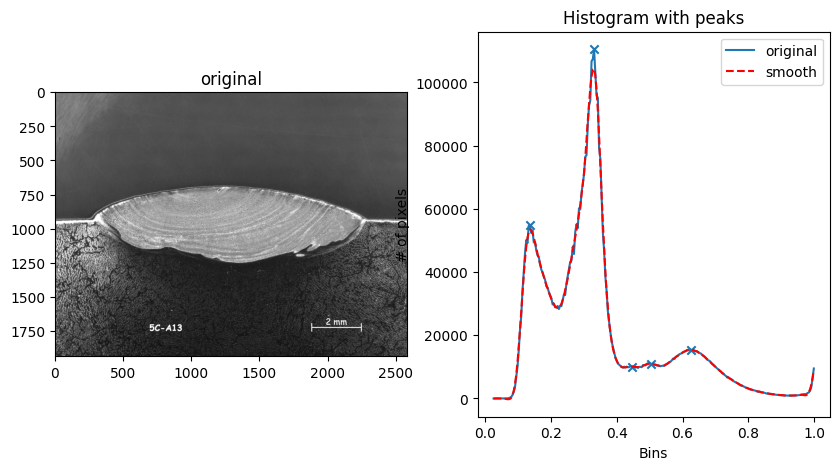

In [242]:
for i, sample in enumerate(subset):

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    ax = axes.ravel()

    ax[0].imshow(sample, cmap=plt.cm.gray)
    ax[0].set_title('original')


    hist, hist_centers = histogram(sample, nbins=256)
    yhat = savgol_filter(hist, 15, 3) # window size 15, polynomial order 3
    ax[1].plot(hist_centers, hist, label='original')
    ax[1].plot(hist_centers, yhat, 'r--', label='smooth')
    peaks, _ = find_peaks(yhat, height=10000)
    ax[1].scatter(hist_centers[peaks], hist[peaks], marker="x")
    ax[1].set_title("Histogram with peaks")
    ax[1].set_xlabel('Bins')
    ax[1].set_ylabel('# of pixels')
    ax[1].legend()

    plt.show()


The height threshold improved the performance. In order to improve it further, I will select the highest three.

In [243]:
peaks

array([ 29,  80, 110, 125, 157])

In [244]:
import pandas as pd
df = pd.DataFrame({'hist':hist[peaks], 'hist_centers': hist_centers[peaks], 'index': peaks})
sorted_peaks = df.sort_values('hist', ascending=False)['index'].values

In this section, I managed to extract the peaks of all the images. The next section will deal in sorting them based on their height and to identify the HQ images based on the hypothesis that they have three peaks, with the thirds one is the _weld-peak_.

# Classifier of images based on number of hist-peaks

This section includes the investigation of the third-peak hypothesis of the HQ images. It contains two functions that sort the peaks by their height and extracts the third-peak. <br>
This approach was proven to be suboptimal and ignored cases when the "dark" peaks converged into one, resulting, in some cases, with two peaks in HQ images. An improved approach is proposed in the [next section](#Optimized_threshold_finder) .

In [245]:
df_img = pd.DataFrame({'fname': img_list_not_measured})

In [246]:
def find_sorted_peaks(fname):
    gray = rgb2gray(io.imread(HOME+IMG_DIR+fname))
    hist, hist_centers = histogram(gray, nbins=256)
    smooth = savgol_filter(hist, 15, 3)
    peaks, _ = find_peaks(smooth, height=10000)
    df = pd.DataFrame({'hist':hist[peaks], 'hist_centers': hist_centers[peaks], 'index': peaks})
    return df.sort_values('hist', ascending=False)['index'].values


In [247]:
df_img['peaks'] = df_img.fname.apply(find_sorted_peaks)
df_img['npeaks'] = df_img.peaks.apply(lambda x: len(x))

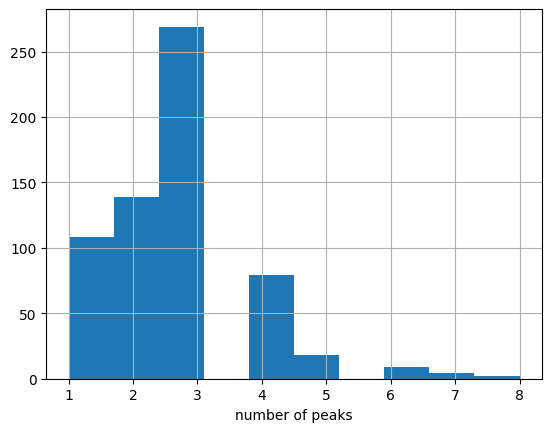

In [248]:
df_img.npeaks.hist()
plt.xlabel('number of peaks')
plt.show()

In [249]:
print('percentage of images with more than 2 peaks: {:.2%}'.format(df_img[df_img.npeaks>2].shape[0]/df_img.shape[0]))

percentage of images with more than 2 peaks: 60.67%


Adding selection of the 3 highest peaks and the height and intensity value.

In [250]:
df_img

,fname,peaks,npeaks
0,12.8x 2Q-A33.jpg,"[19, 52, 158, 75]",4
1,9L-65_10x.jpg,"[53, 76, 154]",3
2,12.8x 5E-A13.jpg,"[47, 19, 129, 103]",4
3,8x 1P-A23.jpg,"[28, 70]",2
4,2B-B2_12.8x.jpg,"[20, 40, 123]",3
...,...,...,...
623,10x 5F-B1N.jpg,"[53, 24, 196]",3
624,12.8x 2P-A23.jpg,"[19, 47, 135]",3
625,8x 4C-C1.jpg,"[72, 33]",2
626,6G-58_10x.jpg,"[24, 42, 118]",3


In [251]:
def get_3rd_peak(item):
    fname, peaks = item
    
    if len(peaks) < 3:
        return 0, 0
    else:
        gray = rgb2gray(io.imread(HOME+IMG_DIR+fname))
        hist, hist_centers = histogram(gray, nbins=256)
        return [hist[peaks[2]], hist_centers[peaks[2]]]
         

In [252]:
df_img['3rd_peak'] = df_img[['fname', 'peaks']].agg(tuple, axis=1).apply(get_3rd_peak)

df_img

In [253]:
df_img[['3rd_peak_y', '3rd_peak_x']] = pd.DataFrame(df_img['3rd_peak'].tolist(), index=df_img.index)

In [254]:
df_img

,fname,peaks,npeaks,3rd_peak,3rd_peak_y,3rd_peak_x
0,12.8x 2Q-A33.jpg,"[19, 52, 158, 75]",4,"[16224, 0.6222297679227942]",16224,0.622230
1,9L-65_10x.jpg,"[53, 76, 154]",3,"[15479, 0.6048372395833334]",15479,0.604837
2,12.8x 5E-A13.jpg,"[47, 19, 129, 103]",4,"[12629, 0.5152503722426471]",12629,0.515250
3,8x 1P-A23.jpg,"[28, 70]",2,"(0, 0)",0,0.000000
4,2B-B2_12.8x.jpg,"[20, 40, 123]",3,"[28376, 0.4853259957107843]",28376,0.485326
...,...,...,...,...,...,...
623,10x 5F-B1N.jpg,"[53, 24, 196]",3,"[13008, 0.7681591796875]",13008,0.768159
624,12.8x 2P-A23.jpg,"[19, 47, 135]",3,"[19879, 0.529296875]",19879,0.529297
625,8x 4C-C1.jpg,"[72, 33]",2,"(0, 0)",0,0.000000
626,6G-58_10x.jpg,"[24, 42, 118]",3,"[17633, 0.462890625]",17633,0.462891


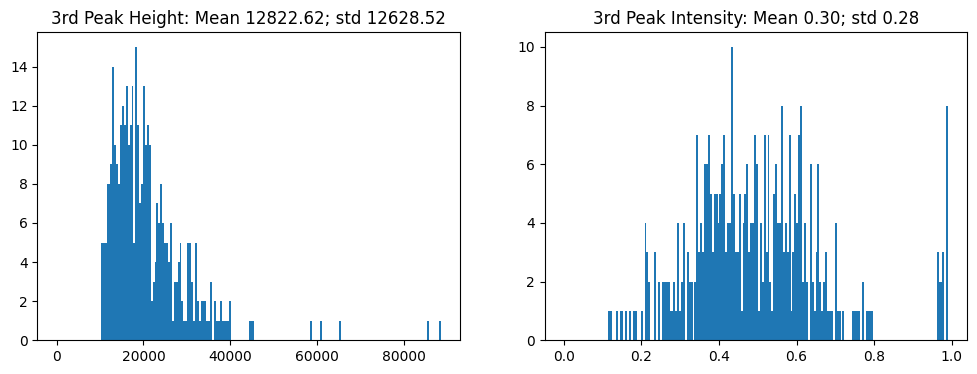

In [255]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
ax = axes.ravel()

ax[0].hist(df_img['3rd_peak_y'],bins=200, range=[1,df_img['3rd_peak_y'].max()])
ax[0].set_title('3rd Peak Height: Mean {:.2f}; std {:.2f}'.format(df_img['3rd_peak_y'].mean(), df_img['3rd_peak_y'].std()))
ax[1].hist(df_img['3rd_peak_x'],bins=200, range=[0.0000001,df_img['3rd_peak_x'].max()])
ax[1].set_title('3rd Peak Intensity: Mean {:.2f}; std {:.2f}'.format(df_img['3rd_peak_x'].mean(), df_img['3rd_peak_x'].std()))

plt.show()

Some of these third peaks are affected by the scale and label pixels.

In [256]:
# Saving a list of candidates in a separate file
df_img[(df_img['3rd_peak_x']<0.95) & (df_img['3rd_peak_x']>0)].to_csv('three_peaks_hist_images.csv')

In [257]:
df_img[(df_img['3rd_peak_x']<0.95) & (df_img['3rd_peak_x']>0)].fname

0      12.8x 2Q-A33.jpg
1         9L-65_10x.jpg
2      12.8x 5E-A13.jpg
4       2B-B2_12.8x.jpg
5      2E-A33_12.8x.jpg
             ...       
622      8x 4F-A11N.jpg
623      10x 5F-B1N.jpg
624    12.8x 2P-A23.jpg
626       6G-58_10x.jpg
627       1M-A23_8x.jpg
Name: fname, Length: 363, dtype: object

In [258]:
three_peak = df_img[(df_img['3rd_peak_x']<0.95) & (df_img['3rd_peak_x']>0)].fname

In [259]:
from PIL import Image, ImageDraw

images = []

width = 200
center = width // 2
color_1 = (0, 0, 0)
color_2 = (255, 255, 255)
max_radius = int(center * 1.5)
step = 8


In [260]:
images = []
for fname in three_peak:
    image = Image.open(HOME+IMG_DIR+fname)
    image.thumbnail((500,500))
    images.append(image)


In [261]:
images[0].save(HOME+'data/processed/third_peak_quickScan.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=300, loop=0)

In [262]:
def get_min_before_3rd_peak(item):
    fname, peaks = item
    gray = rgb2gray(io.imread(HOME+IMG_DIR+fname[0]))
    hist, hist_centers = histogram(gray, nbins=256)
    min_value = np.min(hist[peaks[1]:peaks[2]])
    return hist_centers[peaks[1]:peaks[2]][np.where(hist[peaks[1]:peaks[2]] == min_value)]

In [263]:
df_3peak = df_img[(df_img['3rd_peak_x']<0.95) & (df_img['3rd_peak_x']>0)]


In [264]:
fname, peaks = df_3peak[df_3peak.fname=='2E-A12_12.8x.jpg'].fname, df_3peak[df_3peak.fname=='2E-A12_12.8x.jpg'].peaks
   

In [265]:
df_3peak[5:15]

,fname,peaks,npeaks,3rd_peak,3rd_peak_y,3rd_peak_x
6,7J-57_8x.jpg,"[58, 36, 140]",3,"[17393, 0.5514599609375]",17393,0.551460
8,7J-64_8x.jpg,"[51, 30, 179, 177]",4,"[12430, 0.7014208984375]",12430,0.701421
9,101x 5C-A13.jpg,"[80, 29, 157, 125, 110]",5,"[15447, 0.6249464629289215]",15447,0.624946
12,12.8x 2P-A33.jpg,"[20, 41, 125]",3,"[25071, 0.49181984604779416]",25071,0.491820
13,5H-65_10x.jpg,"[19, 38, 127]",3,"[14156, 0.49972005208333337]",14156,0.499720
14,2E-A12_12.8x.jpg,"[45, 93, 77]",3,"[27194, 0.3072168359375]",27194,0.307217
16,2E-A23_12.8x.jpg,"[25, 43, 94]",3,"[23939, 0.3716096354166667]",23939,0.371610
17,8K-67_10x.jpg,"[24, 45, 154]",3,"[20403, 0.6039640410539215]",20403,0.603964
18,2O-B1_10x.jpg,"[20, 42, 84]",3,"[28215, 0.330078125]",28215,0.330078
19,7I-66_8x.jpg,"[29, 65, 159]",3,"[11707, 0.6232600382965686]",11707,0.623260


\[14.03.2023\] It seems that there are still some strage images that passed the selection above. 
Optimization of the selection procedure will continue...

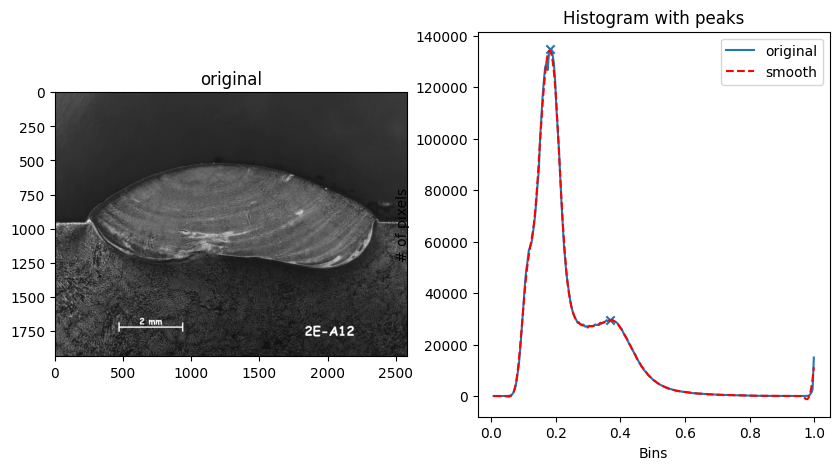

In [266]:
sample = rgb2gray(io.imread(HOME+IMG_DIR+fname.values[0]))
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax = axes.ravel()

ax[0].imshow(sample, cmap=plt.cm.gray)
ax[0].set_title('original')


hist, hist_centers = histogram(sample, nbins=256)
yhat = savgol_filter(hist, 15, 3) # window size 15, polynomial order 3
ax[1].plot(hist_centers, hist, label='original')
ax[1].plot(hist_centers, yhat, 'r--', label='smooth')
peaks, _ = find_peaks(yhat, height=10000, distance=20)
ax[1].scatter(hist_centers[peaks], hist[peaks], marker="x")
ax[1].set_title("Histogram with peaks")
ax[1].set_xlabel('Bins')
ax[1].set_ylabel('# of pixels')
ax[1].legend()

plt.show()

The above example demonstrates that some images have a weld peak that is the second one. <br>
This calls for a refinement of the selection algorithm.<br>
The investigation of an improved approach is presented in the next section.


# <a name='Optimized_threshold_finder'></a> Optimized threshold finder based on a minimum between the "dark" peaks and the possible weld-peak <br>


This section includes a correction of the sorted-peak finder function and a new function that findes the optimized threshold for each image. <br>
In addition, we define HQ image candidates as thosed that have a visible weld-peak in the spectrum and the optimal threshold range is defined between the highest dark peak and the weld peak. 

Additional restriction is added to the find_peak parameters limiting the distance of two peaks to be more than 20 entries away from each other.<br>
Finally, the weld peak is defined as the highest of the peaks that are lower than 1/2 of the highest peak. <br> <br>
__Note__:These were not optimized and their implications on the model efficiency will need to be assessed based on performance.

In [267]:
#Defining again the find_sorted_peaks. This time with a distance restriction and returning also the peaks height
def find_sorted_peaks(fname):
    """
    Find the peaks of a histogram of a grayscaled image and sort them by height.
    """
    gray = rgb2gray(io.imread(HOME+IMG_DIR+fname))
    hist, hist_centers = histogram(gray, nbins=256)
    smooth = savgol_filter(hist, 15, 3)
    peaks, _ = find_peaks(smooth, height=10000, distance=20)  #New parameter: distance
    df = pd.DataFrame({'hist':hist[peaks], 'hist_centers': hist_centers[peaks], 'index': peaks})
    return np.array(df.sort_values('hist', ascending=False)[['index', 'hist_centers', 'hist']].values.tolist())

In [268]:
df_img['peaks'] = df_img.fname.apply(find_sorted_peaks)

In [269]:

def find_optimal_threshold(item):
    """
    An Optimal threshold is defined by the local minimum between the 
    highest dark-peak and the weld-peak. 
    In case of no visible wel-peak, the function returns an optimal 
    threshold at double the location of the highest dark-peak and a 
    range between the dark-peak and the end of the spectrum (i.e., .99).

    Input:
    | - item - a tuple of the file name and the histogram peaks.

    Returns:
    | - an optimal threshold [value on the intensity spectrum (0-1)]
    | - range for further optimization [value on the intensity spectrum (0-1)]
    | - indexes of the range for futher optimization optimal threshold
    """
    fname, peaks = item

    if peaks.shape[0] < 2:  # Controling for histograms with a single peak
        return peaks[0][1]*2, [peaks[0][1], .99], [int(peaks[0][0]), 254]
    else:
        peaks = peaks.transpose()
        weld_peak_cand = peaks[:,[np.where((peaks[2] < peaks[2][0]/2) & (peaks[0] > peaks[0][0]))]]
        
        if weld_peak_cand.shape[-1]==0: # Controling for histograms without low peaks
            return peaks[1][0]*2, [peaks[1][0], .99], [int(peaks[0][0]), 254]
        
        min_index, max_index = int(peaks[0][0]), int(weld_peak_cand[0].flatten()[0] )
        optimal_range = [peaks[1][0], weld_peak_cand[1][0]]

        gray = rgb2gray(io.imread(HOME+IMG_DIR+fname))
        hist, hist_centers = histogram(gray, nbins=256)
        smooth = savgol_filter(hist, 15, 3)
        
        min_val= smooth[min_index: max_index].min()
        
        optimal_thresh = hist_centers[min_index: max_index][
            np.where(smooth[min_index: max_index] == min_val)]
        return optimal_thresh[0], [hist_centers[min_index], hist_centers[max_index]], [min_index, max_index]

    

In [270]:
df_img['opt_tuple'] = df_img[['fname', 'peaks']].agg(tuple, axis=1).apply(find_optimal_threshold)

In [271]:
df_img['HQ_candidate'] = df_img.opt_tuple.apply(lambda x: x[2][1]< 253)

In [272]:
# Spliting the optimization tuple to separate columns
df_img[['thresh', 'optimal_range', 'optimal_range_index']] = pd.DataFrame(df_img.opt_tuple.tolist(), index=df_img.index)

Exporting the new datasheet so it could be used in a batch processing.

In [273]:
df_img[['fname', 'thresh', 'optimal_range', 'optimal_range_index', 'HQ_candidate']].to_csv('uncropped_thresholds_all.csv')

\[15/3/2023\]
The characterization of this method preformance is in progress by the other members of the team.